# Выбор региона для разработки скважин

## Задача <a class = "tocSkip">

Построить для нефтедобывающей компании модель предсказания объема запасов сырья в скважинах, и на основе ее предсказаний при помощи бутстрапа определить регион, где добыча принесёт наибольшую среднюю прибыль, и где вероятность получения убытков составляет менее 2.5%.

## Предоставленные данные <a class = "tocSkip">

Синтетические данные геологоразведки в трёх регионах в форме отдельных файлов:

- `geo_data_0.csv` — данные геологоразведки в регионе 1;
- `geo_data_1.csv` — данные геологоразведки в регионе 2;
- `geo_data_2.csv` — данные геологоразведки в регионе 3.

Согласно описанию к данным:

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — признаки скважины;
- `product` — объём запасов в скважине в тыс. баррелей (целевой признак).

## Предположения и ограничения <a class = "tocSkip">

При проведении работы мы исходили из следующих предположений:

- при разведке региона исследуют 500 скважин, из которых выбирают 200 лучших для разработки;
- бюджет на разработку скважин в одном регионе составляет 10 млрд рублей;
- доход с каждой тыс. баррелей продукта составляет 450 тыс. рублей.

Для предсказания объема запасов сырья может использоваться только линейная модель.

## План работы <a class = "tocSkip">

Работа будет включать шесть этапов:

1. загрузка и первичное изучение данных;
2. исследовательский анализ данных;
3. подготовка данных для обучения модели;
4. обучение модели;
5. подготовка к расчету прибыли и риска убытков;
6. расчет прибыли и риска убытков.

## Подготовка к работе <a class = "tocSkip">

Импортируем необходимые библиотеки:

In [1]:
# импорт библиотек

# общие, работа с данными
import os
import six
import joblib
import warnings
import numpy as np
import pandas as pd

# визуализация графиков
import seaborn as sns
import matplotlib.pyplot as plt

# подготовка данных
from sklearn.model_selection import train_test_split

# ML модели
from sklearn.linear_model import LinearRegression

# обучение и оценка моделей
from sklearn.metrics import mean_squared_error

Настроим параметры отображения графиков и предупреждений:

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

# настройка отображения предупреждений
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = FutureWarning)

Зафиксируем значение параметра `RANDOM_STATE` для всего ноутбука:

In [3]:
# фиксирование значения параметра RANDOM_STATE
RANDOM_STATE = 12345

##  Загрузка и первичное изучение данных

In [4]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# указание пути к данным
PATH = '/content/drive/MyDrive/yandex-practicum-data-science-course-projects/oil-wells-performance-forecast'

In [6]:
# чтение файлов с данными
region_1 = pd.read_csv(os.path.join(PATH, 'geo_data_0.csv'))
region_2 = pd.read_csv(os.path.join(PATH, 'geo_data_1.csv'))
region_3 = pd.read_csv(os.path.join(PATH, 'geo_data_2.csv'))

In [7]:
# сохранение датасетов в словарь
datasets = {'region_1' : region_1,
            'region_2' : region_2,
            'region_3' : region_3}

По каждому датасету изучим пять первых объектов:

In [8]:
# вывод на экран первых пяти объектов каждого датасета
for name, dataset in datasets.items():
    print(name)
    display(dataset.head())
    print()
    print()

region_1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




region_2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




region_3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


- все признаки — числовые, содержат положительные и отрицательные значения и не поддаются прямой интерпретации

Изучим общую информацию о датасетах:

In [9]:
# по каждому датасету вывод на экран общей информации
for name, dataset in datasets.items():
    print(f'{name}\n')
    dataset.info()
    print()
    print()

region_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


region_2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


region_3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5

- по каждому региону доступна информация о 100 тысячах скважин;
- датасеты не содержат явных пропусков.

Дополнительно изучим по каждому датасету:

- количество уникальных значений каждого признака;
- количество полных дубликатов.

In [10]:
# по каждому датасету вывод на экран:
# - количества уникальных значений каждого признака
# - количества полных дубликатов
for name, dataset in datasets.items():
    print(f'{name}\n')
    print('Количество уникальных значений:')
    print()
    display(dataset.nunique().to_frame())
    print()
    print(f'Количество полных дубликатов: {dataset.duplicated().sum()}')
    print()
    print()

region_1

Количество уникальных значений:



,0
id,99990
f0,100000
f1,100000
f2,100000
product,100000



Количество полных дубликатов: 0


region_2

Количество уникальных значений:



,0
id,99996
f0,100000
f1,100000
f2,100000
product,12



Количество полных дубликатов: 0


region_3

Количество уникальных значений:



,0
id,99996
f0,100000
f1,100000
f2,100000
product,100000



Количество полных дубликатов: 0




- датасет `region_2` содержит 12 уникальных значений признака `product`;
- согласно описанию к данным, столбец `id` содержит уникальные идентификаторы скважин, при этом количество уникальных значений `id` в каждом датасете меньше количества объектов;
- датасеты не содержат полных дубликатов.

Изучим объекты с одинаковыми значениями `id`:

In [11]:
# по каждому датасету вывод на экран:
# - количества и процента объектов с одинаковым id
# - первых шести объектов с одинаковыми id
for name, dataset in datasets.items():

    same_id_objects = dataset[dataset.duplicated(['id'], keep = False)].sort_values(by = ['id'])
    same_id_objects_n = len(same_id_objects)
    same_id_objects_share = np.round(same_id_objects_n / len(dataset) * 100, 2)

    print(f'Датасет {name} содержит {same_id_objects_n} объектов с одинаковыми id ({same_id_objects_share}% датасета):\n')
    display(same_id_objects.head(6))
    print()
    print()

Датасет region_1 содержит 20 объектов с одинаковыми id (0.02% датасета):



,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504




Датасет region_2 содержит 8 объектов с одинаковыми id (0.01% датасета):



,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886




Датасет region_3 содержит 8 объектов с одинаковыми id (0.01% датасета):



,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


- объекты с одинаковыми `id` имеют разные признаки и целевой признак; их возникновение могло быть вызвано ошибками при заполнении датасетов / присваивании уникальных идентификаторов скважин;
- доля таких объектов не превышает 0.02%.

###  Выводы

На данном этапе мы загрузили данные и провели их первичное изучение.

По его итогам мы установили:
- каждый датасет содержит информацию о 100 тыс. скважин;
- датасеты не содержат пропусков и полных дубликатов;
- датасет `region_2` содержит 12 уникальных значений признака `product`;
- в каждом датасете есть объекты с одинаковыми `id`, но разными признаками; в зависимости от датасета их доля не превышает 0,02%.

На следующем этапе проведем исследовательский анализ данных.

## Исследовательский анализ данных

На данном этапе исследуем по каждому датасету:

- распределение значений признаков; и
- их корреляцию.

### Целевой признак `product`

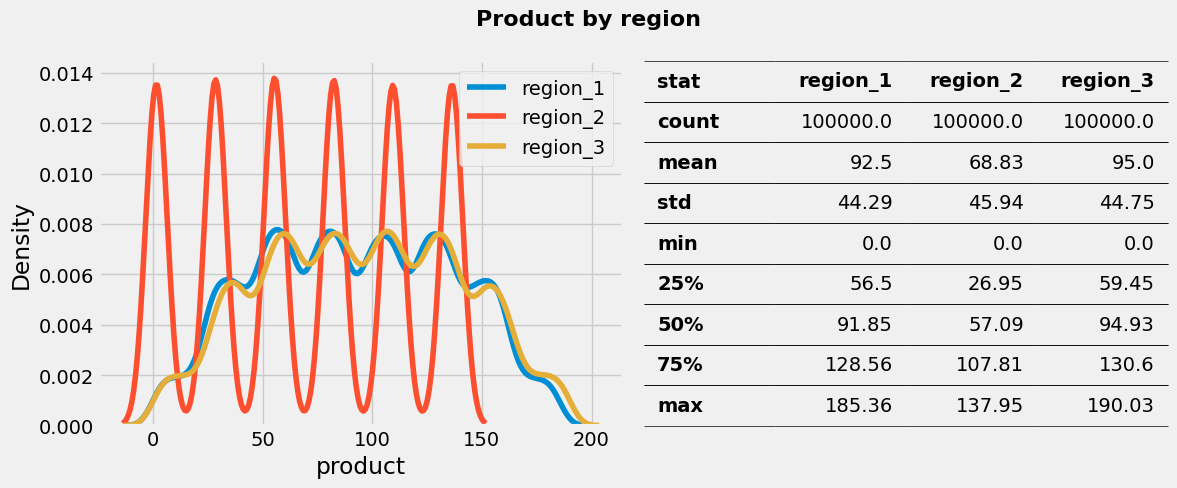

In [12]:
# по каждому датасету вывод на экран графиков распределения и статистик
# значений целевого признака product
regions_stats = None

fig, ax = plt.subplots(ncols   = 2,
                       figsize = (12, 5))

fig.suptitle('Product by region',
             fontsize   = 16,
             fontweight = 'bold')

for name, dataset in datasets.items():
    sns.kdeplot(data  = dataset,
                x     = 'product',
                label = name,
                ax    = ax[0])

    region_stats = dataset['product'].describe().rename(index = name, inplace = True)

    if name == 'region_1': regions_stats = region_stats
    else: regions_stats = pd.concat([regions_stats, region_stats], axis = 1)

ax[0].legend()

regions_stats = regions_stats.round(2).reset_index()
regions_stats.rename(columns = {'index' : 'stat'}, inplace = True)

the_table = ax[1].table(cellText  = regions_stats.values,
                        colLabels = regions_stats.columns,
                        bbox      = (0, 0, 1, 1),
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

plt.tight_layout()
plt.show()

- ни в одном из датасетов распеределение значений признака `product` не похоже на нормальное;
- формы распределений значений признака `product` в датасетах `region_1` и `region_3` похожи; форма распределения значений признака `product` в датасете `region_2` существенно отличается и обусловлена маленьким числом уникальных значений;
- в регионе 3 наибольшее среднее значение запасов сырья.

### Признаки `f0`, `f1`, `f2`

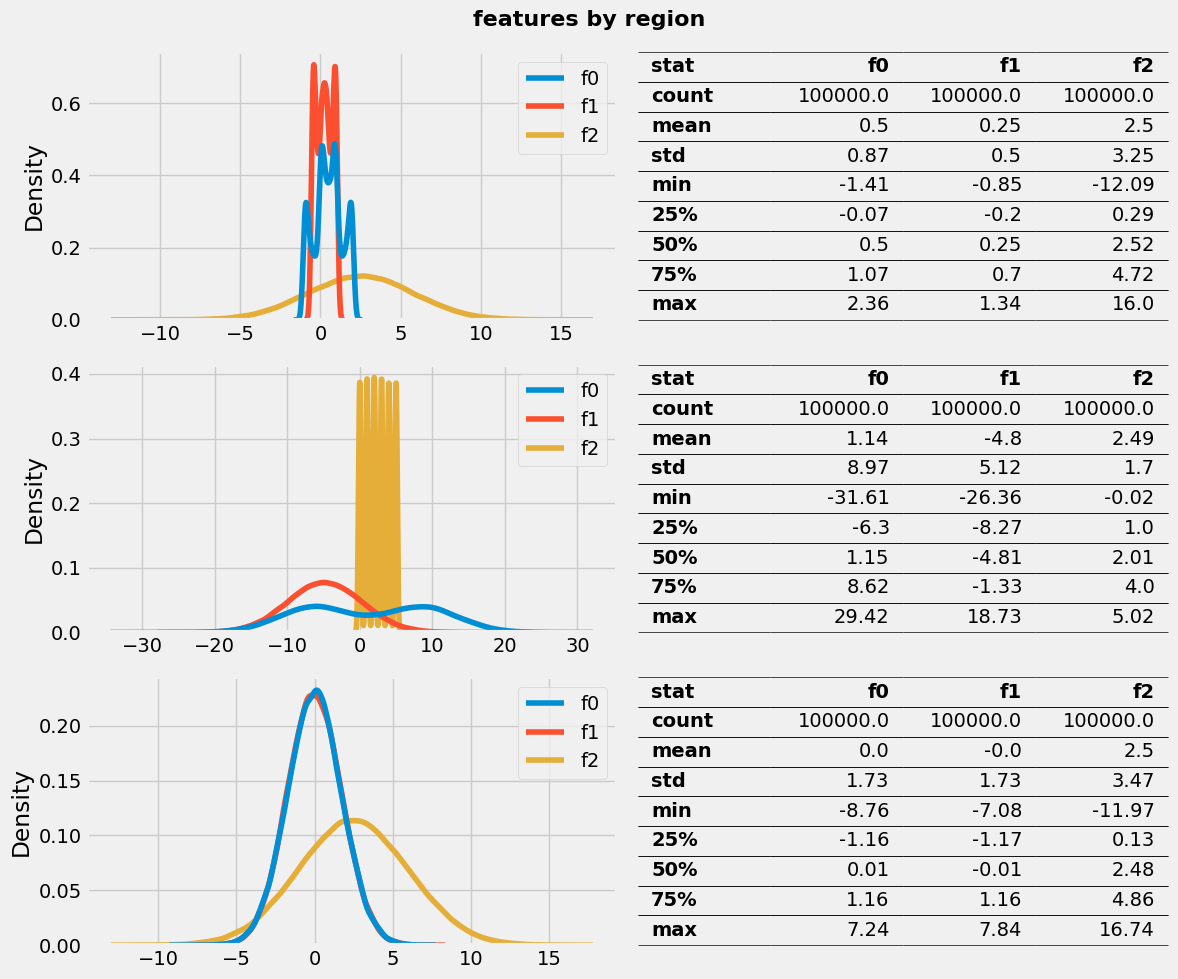

In [13]:
# по каждому датасету вывод на экран графиков распределения и статистик
# значений признаков
regions_stats = None

fig, ax = plt.subplots(ncols   = 2,
                       nrows   = 3,
                       figsize = (12, 10))

fig.suptitle('features by region',
             fontsize   = 16,
             fontweight = 'bold')

for i, (name, dataset) in enumerate(datasets.items()):

    features = dataset.drop(columns = ['product'])

    sns.kdeplot(features,
                common_norm = False,
                ax          = ax[i][0])

    features_stats = features.describe().round(2).reset_index()
    features_stats.rename(columns = {'index' : 'stat'}, inplace = True)

    the_table = ax[i][1].table(cellText  = features_stats.values,
                               colLabels = features_stats.columns,
                               bbox      = (0, 0, 1, 1),
                               edges     = 'horizontal')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)

    for k, cell in six.iteritems(the_table._cells):
        if k[1] == 0: cell.set_text_props(ha = 'left')
        else: cell.set_text_props(ha = 'right')
        if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

    ax[i][1].axis('off')

plt.tight_layout()
plt.show()

- формы распределений значений признаков в разных регионах отличаются

### Корреляция

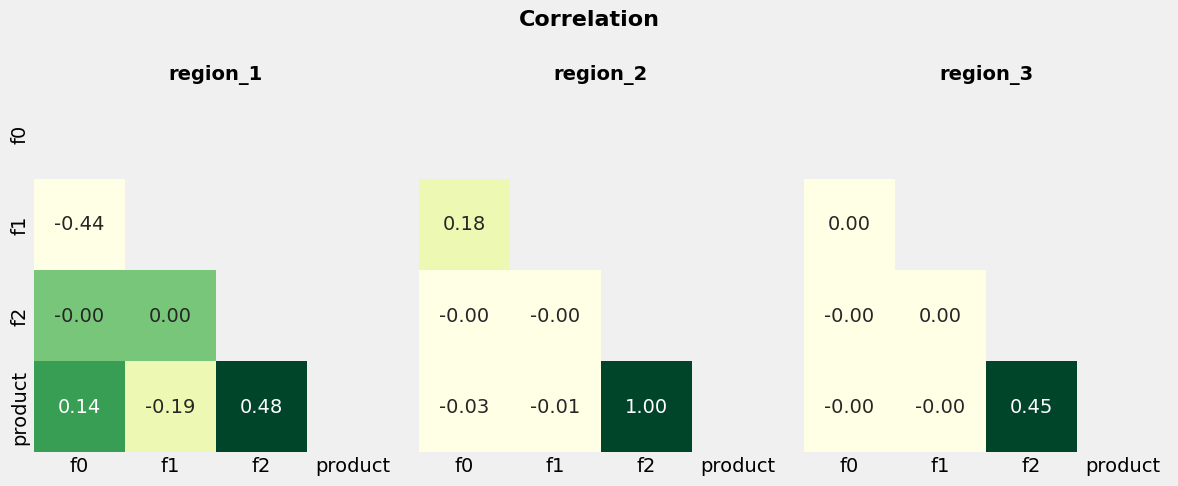

In [14]:
# по каждому датасету вывод на экран тепловой карты корреляции признаков
fig, ax = plt.subplots(ncols   = 3,
                       figsize = (12, 5),
                       sharey  = True)

for i, (name, dataset) in enumerate(datasets.items()):

    corr_matrix = dataset.corr()
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True

    ax[i].set_title(name,
                    fontsize   = 14,
                    fontweight = 'bold')

    sns.heatmap(data   = corr_matrix,
                cmap   = plt.colormaps['YlGn'].resampled(7),
                annot  = True,
                fmt    = '.2f',
                cbar   = False,
                square = True,
                mask   = mask,
                ax     = ax[i])

    ax[i].grid(None)

fig.suptitle('Correlation',
             fontsize   = 16,
             fontweight = 'bold')

plt.tight_layout()
plt.show()

- в каждом датасете наибольшую корреляцию с целевым признаком `product` демонстрирует признак `f2`, при этом в датасете `region_2` корреляция между данными признаками равна 1.

### Выводы

На данном этапе мы исследовали по каждому датасету:

- распределение значений признаков; и
- их корреляцию.

**Целевой признак `product`**

- ни в одном из датасетов распеределение значений признака `product` не похоже на нормальное;
- формы распределений значений признака `product` в датасетах `region_1` и `region_3` похожи; форма распределения значений признака `product` в датасете `region_2` существенно отличается и обусловлена маленьким числом уникальных значений;
- в регионе 3 наибольшее среднее значение запасов сырья.

**Корреляция**

- в каждом датасете наибольшую корреляцию с целевым признаком `product` демонстрирует признак `f2`, при этом в датасете `region_2` корреляция между данными признаками равна 1

## Подготовка данных для обучения модели

На данном этапе:

- устраним дубликаты в значениях `id`;
- по каждому датасету:
    - сохраним признаки и целевой признак в отдельные переменные;
    - разделим датасет на обучающую и тестовую выборки.

### Устранение дубликатов в значениях `id`

С учетом небольшого количества объектов с одинаковыми `id` (менее 0,02%) устраним дубликаты путем удаления соответствующих объектов:

In [15]:
# по каждому датасету:
for name, dataset in datasets.items():

    # удаление объектов с одинаковыми id
    dataset.drop_duplicates(subset='id', keep=False, inplace=True)

    # проверка удаления объектов
    same_ids_n = dataset.duplicated(subset=['id']).sum()
    print(f'Датасет {name} содержит {same_ids_n} объектов с одинаковыми id')

Датасет region_1 содержит 0 объектов с одинаковыми id
Датасет region_2 содержит 0 объектов с одинаковыми id
Датасет region_3 содержит 0 объектов с одинаковыми id


### Создание переменных с признаками и целевым признаком и разделение датасетов на обучающую и тестовую выборки

При разделении датасетов на обучающую и тестовую выборки будем использовать соотношение 3:1:

In [16]:
# фиксирование доли тестовой выборки
TEST_SIZE = 0.25

In [17]:
# по каждому датасету сохранение признаков и целевого признака в отдельные переменные
features_1 = region_1.drop(columns = ['id', 'product'])
features_2 = region_2.drop(columns = ['id', 'product'])
features_3 = region_3.drop(columns = ['id', 'product'])
target_1 = region_1['product']
target_2 = region_2['product']
target_3 = region_3['product']

In [18]:
# по каждому датасету разделение данных на обучуающую и тестовую выборки
features_1_train, features_1_test, target_1_train, target_1_test = train_test_split(
    features_1, target_1, test_size = TEST_SIZE, random_state = RANDOM_STATE)

features_2_train, features_2_test, target_2_train, target_2_test = train_test_split(
    features_2, target_2, test_size = TEST_SIZE, random_state = RANDOM_STATE)

features_3_train, features_3_test, target_3_train, target_3_test = train_test_split(
    features_3, target_3, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [19]:
# создание словаря с выборками
datasets_preprocessed = {'region_1' : {'train' : [features_1_train, target_1_train],
                                       'test'  : [features_1_test, target_1_test]},
                         'region_2' : {'train' : [features_2_train, target_2_train],
                                       'test'  : [features_2_test, target_2_test]},
                         'region_3' : {'train' : [features_3_train, target_3_train],
                                       'test'  : [features_3_test, target_3_test]}
                         }

## Обучение модели

На данном этапе обучим линейную модель и для каждого региона предскажем объем запасов сырья в скважинах.

In [20]:
# создание модели
lr_model = LinearRegression()

In [21]:
# создание словаря для сохранения предсказаний
predictions = {'region_1' : None,
               'region_2' : None,
               'region_3' : None}

In [22]:
# для каждого датасета
for name, datasets in datasets_preprocessed.items():

    features_train, target_train = datasets_preprocessed[name]['train']
    features_test, target_test = datasets_preprocessed[name]['test']

    # обучение модели на обучающей выборки
    lr_model.fit(features_train, target_train)

    # получение предсказаний на тестовой выборке
    predictions[name] = lr_model.predict(features_test)

    # расчет и вывод на экран среднего предсказанного объема сырья и RMSE
    predictions_mean = np.mean(predictions[name])
    rmse = mean_squared_error(target_test, predictions[name], squared = False)

    print(name)
    print('Mean product prediction (in thousands): {:.2f}'.format(predictions_mean))
    print('RMSE score: {:.2f}'.format(rmse))
    print()

region_1
Mean product prediction (in thousands): 92.42
RMSE score: 37.72

region_2
Mean product prediction (in thousands): 68.98
RMSE score: 0.89

region_3
Mean product prediction (in thousands): 95.12
RMSE score: 39.98



- **средний запас предсказанного сырья**: наибольшее значение (95,12 тыс. баррелей) наблюдается в регионе 3, наименьшее значение (68,98 тыс. баррелей) - в регионе 2;
- **RMSE**: регион 3 также показал наибольшее значение *RMSE* (39,98), что говорит о низкой способности модели корректно предсказывать объем сырья по данному региону. Напротив, регион 2 показал значение *RMSE* 0,89, т.е. модель по данному региону достаточно точно предсказывает объем сырья.

## Подготовка к расчету прибыли и риска убытков

На данном этапе:
- создадим переменные с фиксированными значениями для расчетов;
- создадим функции `calc_profit` и `get_bootstrap` для оптимзации вычислений;
- рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный результат со средним предсказанным запасом сырья в каждом регионе.

In [23]:
# создание переменных с фиксированными значениями для расчетов
SURVEYED_N       = 500
DEVELOPED_N      = 200
CAPEX            = 1e7
REVENUE_PER_UNIT = 450
TARGET_LOSS_PROB = 2.5

In [24]:
# создание функции calc_profit
def calc_profit(products):
    '''
    Функция расчитывает прибыль/убыток от разработки скважит

    Аргументы:
    - products — фактический объем запасов сырья в скважинах
    '''

    return np.sum(products) * REVENUE_PER_UNIT - CAPEX

In [25]:
# создание функции get_bootstrap
def get_bootstrap(predictions,
                  products,
                  boot_conf_level = 0.95,
                  boot_it = 1000):

    '''
    Функция при помощи бутстрапа расчитывает:
    - прибыль от разработки скважин и ее доверительный интервал;
    - вероятность получить убыток

    Аргументы:
    - predictions — предсказанный объем запасов сырья в скважинах;
    - products — фактический объем запасов сырья в скважинах;
    - boot_conf_level — доверительный интервал;
    - boot_it — количество итераций бутстрапа.
    '''

    profits = []

    for i in range(boot_it):
        samples_idx = np.random.choice(len(predictions), size = SURVEYED_N, replace = True)

        samples_predictions = predictions[samples_idx]
        samples_products = products.values[samples_idx]

        develop_idx = samples_predictions.argsort()[::-1][:DEVELOPED_N]

        develop_products = samples_products[develop_idx]

        profits.append(calc_profit(develop_products))

        left_ci = (1 - boot_conf_level) / 2
        right_ci = 1 - (1 - boot_conf_level) / 2

        ci = pd.Series(profits).quantile([left_ci, right_ci]).values

        loss_prob = np.where(np.array(profits) < 0, 1, 0).mean() * 100

    return profits, ci, loss_prob

In [26]:
# расчет достаточного объёма сырья для безубыточной разработки новой скважины
break_even_product = CAPEX / DEVELOPED_N / REVENUE_PER_UNIT

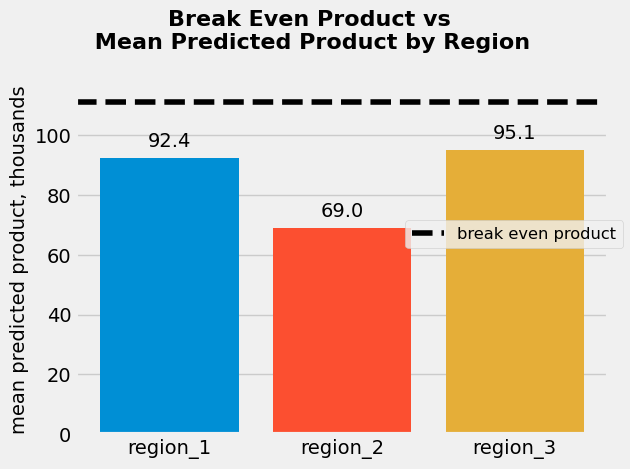

In [27]:
# вывод на экран графика средних предсказанных значений объема сырья
# по каждому региону и достаточного объёма сырья для безубыточной разработки
# новой скважины
fig = plt.figure()

fig.suptitle('Break Even Product vs\n Mean Predicted Product by Region', fontsize = 16, fontweight = 'bold')

for name, prediction in predictions.items():
    bars = plt.bar(x = name,
            height = np.mean(prediction))

    plt.bar_label(bars,
                  fmt     = '%.1f',
                  padding = 5)

plt.axhline(break_even_product,
            color     = 'black',
            linestyle = '--',
            label     = 'break even product')

plt.ylabel('mean predicted product, thousands', fontsize = 14)

plt.grid(axis='x')

fig.legend(loc = 'center right', fontsize = 'small')
plt.tight_layout()
plt.show()

- ни в одном из трех регионов средний предсказанный запас сырья не превышает достаточный объём сырья для безубыточной разработки новой скважины.

## Расчет прибыли и риска убытков

На данном этапе по каждому региону применим бутстрап и рассчитаем прибыль и риск убытков:

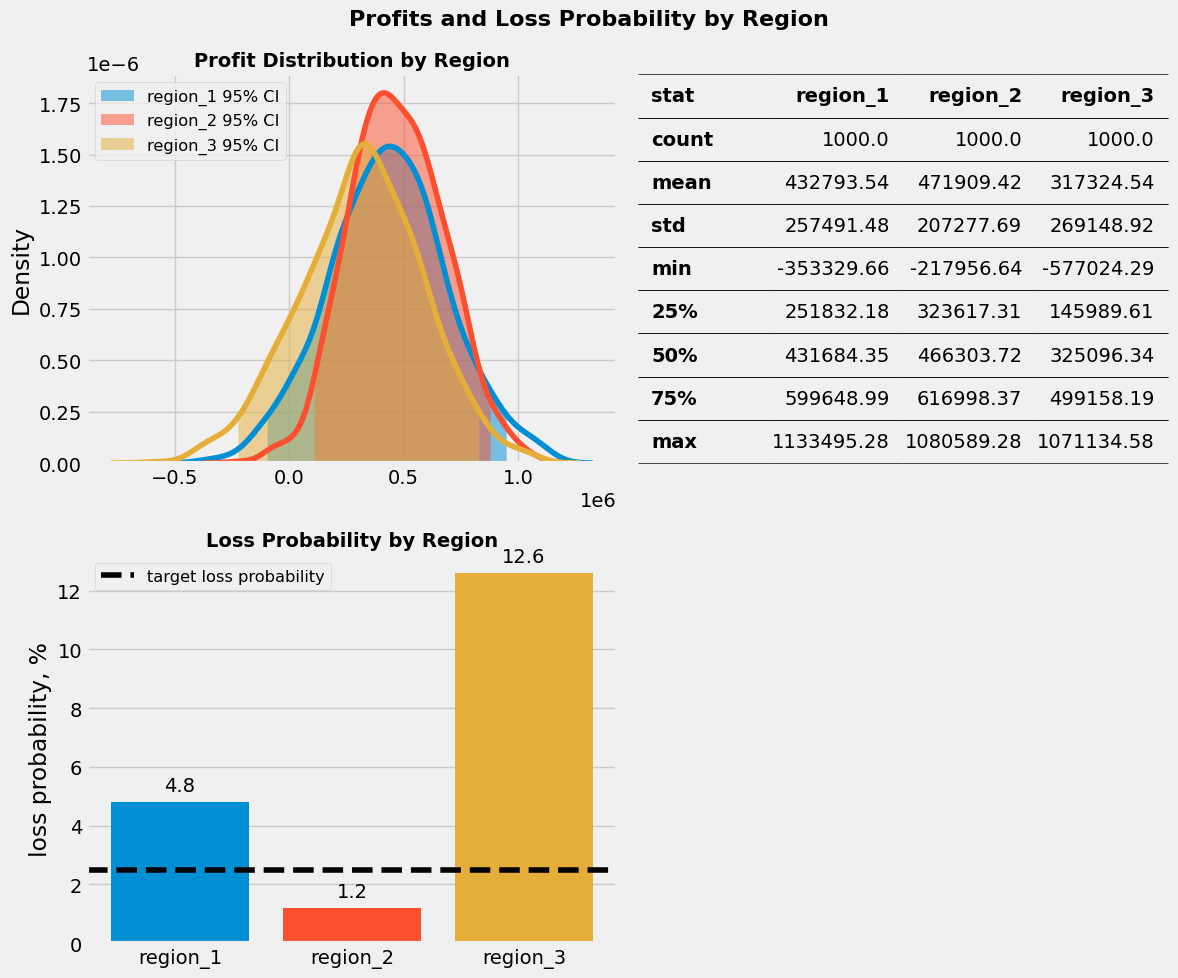

In [28]:
# по каждому региону вызов функции get_bootstrap и визуализация результатов
fig, ax = plt.subplots(ncols = 2,
                       nrows = 2,
                       figsize = (12, 10))

ax = ax.flatten()

fig.suptitle('Profits and Loss Probability by Region',
             fontsize = 16,
             fontweight = 'bold')

profits_stats = None

for region in predictions:

    profits, ci, loss_prob = get_bootstrap(predictions[region], datasets_preprocessed[region]['test'][1])

    if profits_stats is None:
        profits_stats = pd.Series(profits, name = region).describe().round(2)
    else:
        profits_stats = pd.concat(
            [profits_stats,
             pd.Series(profits, name = region).describe().round(2)], axis = 1)

    g = sns.kdeplot(data = profits,
                    ax = ax[0])

    x = g.lines[-1].get_xdata()
    y = g.lines[-1].get_ydata()

    g.fill_between(x,
                   y,
                   0,
                   where = (x > ci[0]) & (x < ci[1]),
                   alpha = 0.5,
                   label = f'{region} 95% CI')

    bars = ax[2].bar(x      = region,
              height = loss_prob)

    ax[2].bar_label(bars,
                  fmt     = '%.1f',
                  padding = 5)

ax[0].set_title('Profit Distribution by Region',
                fontsize = 14,
                fontweight = 'bold')

ax[0].legend(fontsize       = 'small')

profits_stats.reset_index(inplace = True)
profits_stats.rename(columns = {'index' : 'stat'}, inplace = True)

the_table = ax[1].table(cellText  = profits_stats.values,
                        colLabels = profits_stats.columns,
                        bbox      = (0, 0, 1, 1),
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

ax[2].set_title('Loss Probability by Region',
                fontsize = 14,
                fontweight = 'bold')

ax[2].axhline(TARGET_LOSS_PROB,
            color     = 'black',
            linestyle = '--',
            label     = 'target loss probability')

ax[2].legend(fontsize       = 'small')
ax[2].set_ylabel('loss probability, %')
ax[2].grid(axis = 'x')

ax[3].axis('off')

plt.tight_layout()
plt.show()

- по каждому региону распределение значений прибыли стремится к нормальному;
- наибольшее среднее значение прибыли (458.8 млн) демонстрирует регион 2;
- только в регионе 2:
    - левая граница 95%-го доверительного интервала прибыли является положительной; и
    - вероятность получить убыток (0.9%) ниже целевого значения 2.5%.

С учетом вышеизложенного мы рекоммендуем разрабатывать скважины в регионе 2.

## Общие выводы

**Введение**

*Задача*

Перед нами была поставлена задача построить для нефтедобывающей компании модель предсказания объема запасов сырья в скважинах, и на основе ее предсказаний при помощи бутстрапа определить регион, где добыча принесёт наибольшую среднюю прибыль, и где вероятность получения убытков составляет менее 2,5%.

*Предоставленные данные*

Синтетические данные геологоразведки в трёх регионах в форме отдельных файлов:

- `geo_data_0.csv` — данные геологоразведки в регионе 1;
- `geo_data_1.csv` — данные геологоразведки в регионе 2;
- `geo_data_2.csv` — данные геологоразведки в регионе 3.

Согласно описанию к данным:

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — признаки скважины;
- `product` — объём запасов в скважине в тыс. баррелей (целевой признак).

*Предположения и ограничения*

При проведении работы мы исходили из следующих предположений:

- при разведке региона исследуют 500 скважин, из которых выбирают 200 лучших для разработки;
- бюджет на разработку скважин в одном регионе составляет 10 млрд рублей;
- доход с каждой тыс. баррелей продукта составляет 450 тыс. рублей.

Для предсказания объема запасов сырья может использоваться только линейная модель.

*Основные этапы работы*

Работа над задачей включала шесть этапов:

1. загрузка и первичное изучение данных;
2. исследовательский анализ данных;
3. подготовка данных для обучения модели;
4. обучение модели;
5. подготовка к расчету прибыли и риска убытков;
6. расчет прибыли и риска убытков.

**1. Загрузка и первичное изучение данных**

На данном этапе мы загрузили данные и провели их первичное изучение.

По его итогам мы установили:

- каждый датасет содержит информацию о 100 тыс. скважин;
- датасеты не содержат пропусков и полных дубликатов;
- датасет `region_2` содержит 12 уникальных значений признака `product`;
- в каждом датасете есть объекты с одинаковыми `id`, но разными признаками; в зависимости от датасета их доля не превышает 0,02%.

**2. Исследовательский анализ данных**

На данном этапе мы исследовали по каждому датасету:

- распределение значений признаков; и
- их корреляцию.

*Целевой признак `product`*

- ни в одном из датасетов распеределение значений признака `product` не похоже на нормальное;
- формы распределений значений признака `product` в датасетах `region_1` и `region_3` похожи; форма распределения значений признака `product` в датасете `region_2` существенно отличается и обусловлена маленьким числом уникальных значений;
- в регионе 3 наибольшее среднее значение запасов сырья.

*Корреляция*

- в каждом датасете наибольшую корреляцию с целевым признаком `product` демонстрирует признак `f2`, при этом в датасете `region_2` корреляция между данными признаками равна 1.

**3. Подготовка данных для обучения модели**

На данном этапе мы:

- устранили дубликаты в значениях `id` путем удаления содержащих дубликаты объектов;
- по каждому датасету:
    - сохранили признаки и целевой признак в отдельные переменные;
    - разделили датасет на обучающую и тестовую выборки в пропорции 3:1.

**4. Обучение модели**

На данном этапе мы обучили линейную модель и для каждого региона предсказали объем запасов сырья в скважинах:

- *средний запас предсказанного сырья*: наибольшее значение (95,12 тыс. баррелей) наблюдается в регионе 3, наименьшее значение (68,98 тыс. баррелей) - в регионе 2;
- *RMSE*: регион 3 также показал наибольшее значение *RMSE* (39,98), что говорит о низкой способности модели корректно предсказывать объем сырья по данному региону. Напротив, регион 2 показал значение *RMSE* 0,89, т.е. модель по данному региону достаточно точно предсказывает объем сырья.

**5. Подготовка к расчету прибыли и риска убытков**

На данном этапе мы:

- создали переменные с фиксированными значениями для расчетов;
- создали функции `calc_profit` и `get_bootstrap` для оптимзации вычислений;
- рассчитали достаточный объём сырья для безубыточной разработки новой скважины и сравнили полученный результат со средним предсказанным запасом сырья в каждом регионе: ни в одном из трех регионов средний предсказанный запас сырья не превышает достаточный объём сырья для безубыточной разработки новой скважины.

**6. Расчет прибыли и риска убытков**

На данном этапе мы по каждому региону применили бутстрап и рассчитали прибыль и риск убытков:

- по каждому региону распределение значений прибыли стремится к нормальному;
- наибольшее среднее значение прибыли (471.9 млн рублей) демонстрирует регион 2;
- только в регионе 2:
    - левая граница 95%-го доверительного интервала прибыли является положительной; и
    - вероятность получить убыток (1.2%) ниже целевого значения 2.5%.

С учетом вышеизложенного мы рекоммендуем разрабатывать скважины в регионе 2.